In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data
import numpy as np
import statistics as stats
import math as math
plt.rcParams['figure.figsize'] = [12, 6]
idx = pd.IndexSlice

In [3]:
DATA_STORE = '../../../Data-Daily/india_asset.h5'

In [4]:
with pd.HDFStore(DATA_STORE) as store:
    nifty50_m = (store['/nse/nifty50/metadata'])
tickers = nifty50_m.dropna().symbol.to_list()
print(tickers)

['APSE', 'ASPN', 'AXBK', 'BAJA', 'BJFN', 'BJFS', 'BPCL', 'BRTI', 'BRIT', 'CIPL', 'COAL', 'DIVI', 'REDY', 'GAIL', 'GRAS', 'HCLT', 'HDBK', 'HDFL', 'HROM', 'HALC', 'HLL', 'HDFC', 'ICBK', 'ITC', 'IOC', 'INBK', 'INFY', 'JSTL', 'KTKM', 'LART', 'MAHM', 'MRTI', 'NTPC', 'NEST', 'ONGC', 'PGRD', 'RELI', 'SBIL', 'SHCM', 'SBI', 'SUN', 'TCS', 'TAMO', 'TISC', 'TEML', 'TITN', 'UPLL', 'ULTC', 'WIPR']


In [5]:
columns = ['close','high','low','open','volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = store['/ind/nifty500_investing/prices'].loc[idx[tickers, :], columns]
prices.head(3)

close    high     low    open   volume
ticker date                                               
APSE   2008-01-02  261.49  264.80  254.00  262.05  3519075
       2008-01-03  255.16  262.94  252.23  261.00  2525290
       2008-01-04  248.07  258.96  246.60  255.76  2753975

In [6]:
stock = 'HDBK'
days = 126

In [7]:
stock_data = prices.loc[stock].tail(days)
stock_data.tail()

,close,high,low,open,volume
date,,,,,
2021-02-17,1586.5,1621.80,1583.00,1620.00,6397213
2021-02-18,1554.3,1605.95,1548.00,1605.95,7360280
2021-02-19,1539.1,1564.20,1533.00,1545.00,8569754
2021-02-22,1548.0,1573.90,1539.45,1545.05,14725919
2021-02-23,1530.0,1557.25,1523.05,1553.10,9119570


In [8]:
stock_data_signal = pd.DataFrame(index=stock_data.index)
stock_data_signal['price'] = stock_data.close

#### Support and Resistance

In [9]:
def trading_support_resistance(data, bin_width=20):  
    data['sup_tolerance'] = pd.Series(np.zeros(len(data)))  
    data['res_tolerance'] = pd.Series(np.zeros(len(data)))  
    data['sup_count'] = pd.Series(np.zeros(len(data)))  
    data['res_count'] = pd.Series(np.zeros(len(data)))  
    data['sup'] = pd.Series(np.zeros(len(data)))  
    data['res'] = pd.Series(np.zeros(len(data)))  
    data['positions'] = pd.Series(np.zeros(len(data)))  
    data['signal'] = pd.Series(np.zeros(len(data)))  
    in_support=0  
    in_resistance=0
    
    for x in range((bin_width - 1) + bin_width, len(data)):      
        data_section = data[x - bin_width:x + 1]      
        support_level=min(data_section['price'])      
        resistance_level=max(data_section['price'])      
        range_level=resistance_level-support_level      
        data['res'][x]=resistance_level      
        data['sup'][x]=support_level      
        data['sup_tolerance'][x]=support_level + 0.1 * range_level
        data['res_tolerance'][x]=resistance_level - 0.1 * range_level
        
        if data['price'][x]>=data['res_tolerance'][x] and\
        data['price'][x] <= data['res'][x]:
            in_resistance+=1          
            data['res_count'][x]=in_resistance      
        elif data['price'][x] <= data['sup_tolerance'][x] and \
        data['price'][x] >= data['sup'][x]:
            in_support += 1          
            data['sup_count'][x] = in_support      
        else:
            in_support=0
            in_resistance=0
        if in_resistance>2:          
            data['signal'][x]=1      
        elif in_support>2:
            data['signal'][x]=0      
        else:
            data['signal'][x] = data['signal'][x-1]
    data['positions']=data['signal'].diff()

In [10]:
trading_support_resistance(stock_data_signal, bin_width=15)

In [11]:
# stock_data_signal.tail(40)

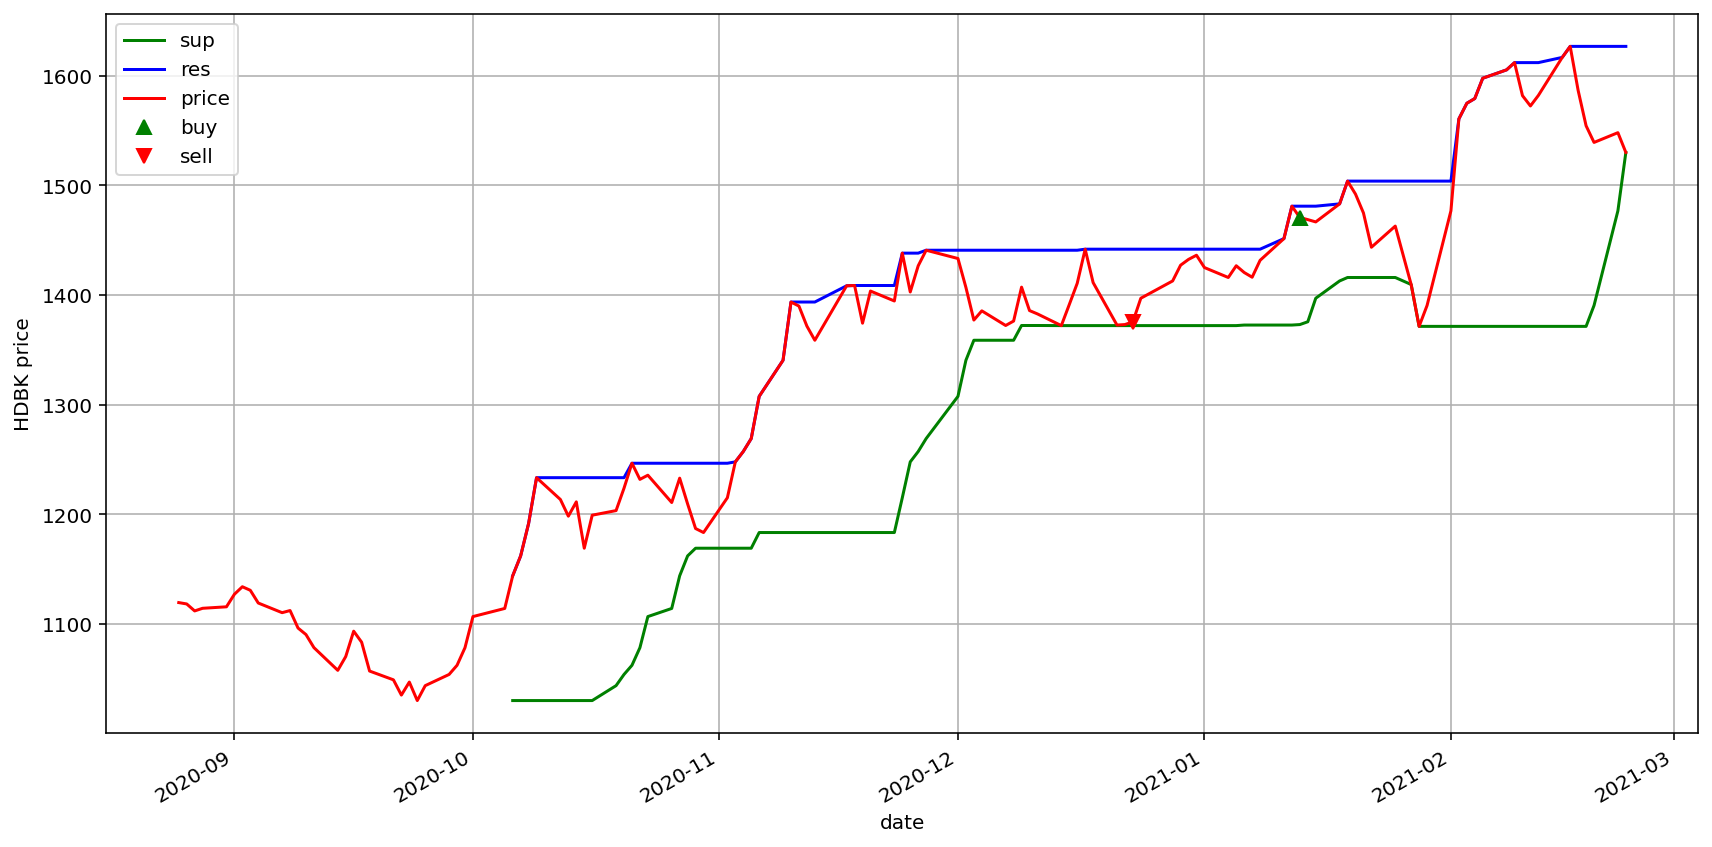

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel=f'{stock} price')
stock_data_signal['sup'].plot(ax=ax1, color='g', lw=1.5)
stock_data_signal['res'].plot(ax=ax1, color='b', lw=1.5)
stock_data_signal['price'].plot(ax=ax1, color='r', lw=1.5)
ax1.plot(stock_data_signal.loc[stock_data_signal.positions == 1.0].index,
         stock_data_signal.price[stock_data_signal.positions == 1.0],
         '^', 
         markersize=7, 
         color='g',label='buy')
ax1.plot(stock_data_signal.loc[stock_data_signal.positions == -1.0].index,
         stock_data_signal.price[stock_data_signal.positions == -1.0],
         'v', markersize=7, color='r',label='sell')
ax1.grid(True)
plt.legend()
plt.tight_layout()

In [13]:
# stock_data_signal.positions[stock_data_signal.positions.diff()!=0.0].count()
# stock_data_signal.price[stock_data_signal.positions == 1.0].count()
# stock_data_signal.price[stock_data_signal.positions == -1.0].count()

#### Simple Moving Average (SMA)

In [14]:
stock_data = prices.loc[stock].tail(days)
stock_data.tail()

,close,high,low,open,volume
date,,,,,
2021-02-17,1586.5,1621.80,1583.00,1620.00,6397213
2021-02-18,1554.3,1605.95,1548.00,1605.95,7360280
2021-02-19,1539.1,1564.20,1533.00,1545.00,8569754
2021-02-22,1548.0,1573.90,1539.45,1545.05,14725919
2021-02-23,1530.0,1557.25,1523.05,1553.10,9119570


In [15]:
close = stock_data.close

In [16]:
time_period = 20 # number of days over which to average
history = [] # to track a history of prices
sma_values = [] # to track simple moving average values
for close_price in close:
    history.append(close_price)
    if len(history) > time_period: # we remove oldest price because we only average over last 'time_period' prices
        del (history[0])

    sma_values.append(stats.mean(history))

stock_data = stock_data.assign(ClosePrice=pd.Series(close, index=stock_data.index))
stock_data = stock_data.assign(Simple20DayMovingAverage=pd.Series(sma_values, index=stock_data.index))

In [17]:
stock_data.head(3)

,close,high,low,open,volume,ClosePrice,Simple20DayMovingAverage
date,,,,,,,
2020-08-25,1119.70,1127.00,1106.20,1119.0,13800972,1119.70,1119.700
2020-08-26,1118.45,1131.75,1109.50,1121.0,12595131,1118.45,1119.075
2020-08-27,1112.10,1129.90,1106.25,1125.8,10323015,1112.10,1116.750


In [18]:
close_price = stock_data['ClosePrice']
sma = stock_data['Simple20DayMovingAverage']

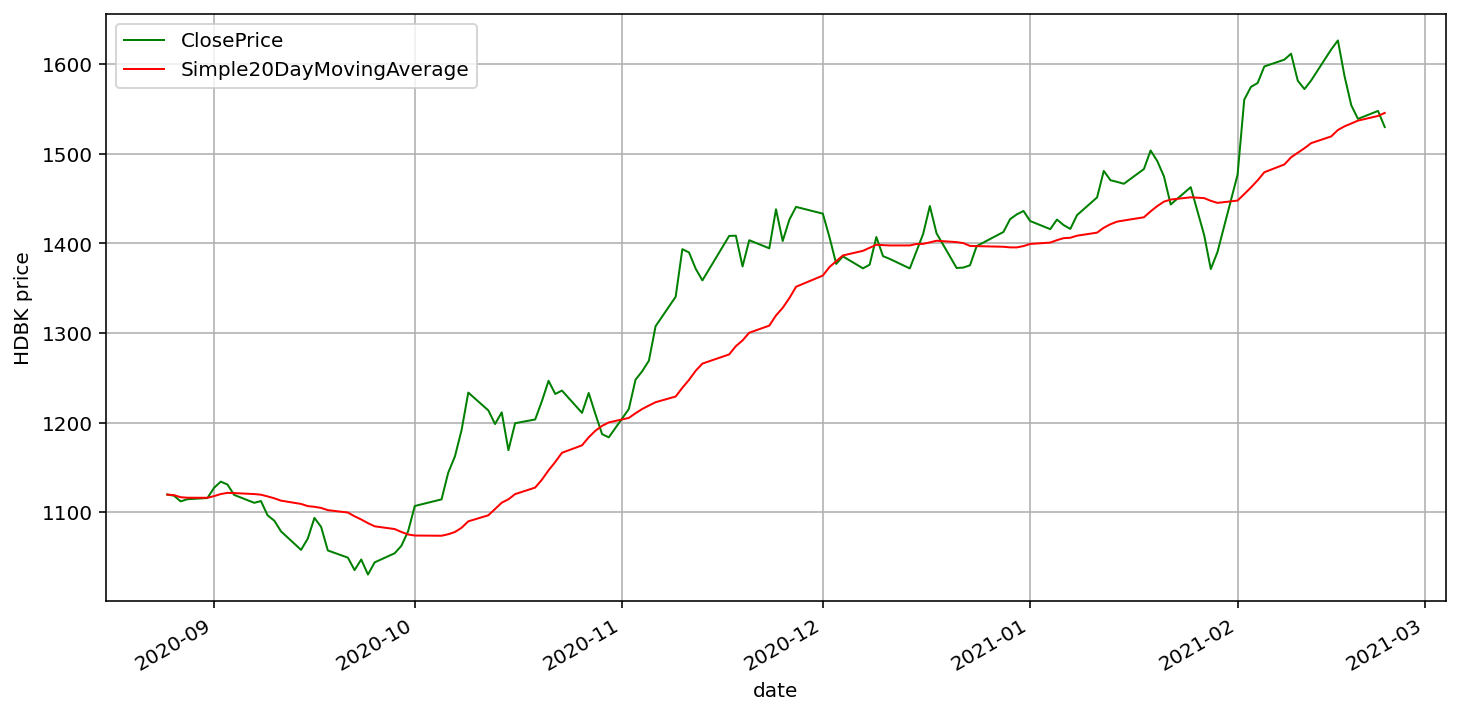

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel=f'{stock} price')
close_price.plot(ax=ax1, color='g', lw=1., legend=True)
sma.plot(ax=ax1, color='r', lw=1., legend=True)
ax1.grid(True)
plt.show()

#### Exponential Moving Average (EMA)

In [20]:
stock_data = prices.loc[stock].tail(days)
stock_data.tail()

,close,high,low,open,volume
date,,,,,
2021-02-17,1586.5,1621.80,1583.00,1620.00,6397213
2021-02-18,1554.3,1605.95,1548.00,1605.95,7360280
2021-02-19,1539.1,1564.20,1533.00,1545.00,8569754
2021-02-22,1548.0,1573.90,1539.45,1545.05,14725919
2021-02-23,1530.0,1557.25,1523.05,1553.10,9119570


In [21]:
close = stock_data.close

In [22]:
num_periods = 20 # number of days over which to average
K = 2 / (num_periods + 1) # smoothing constant
ema_p = 0

ema_values = [] # to hold computed EMA values
for close_price in close:
    if (ema_p == 0): # first observation, EMA = current-price
        ema_p = close_price
    else:
        ema_p = (close_price - ema_p) * K + ema_p

    ema_values.append(ema_p)

stock_data = stock_data.assign(ClosePrice=pd.Series(close, index=stock_data.index))
stock_data = stock_data.assign(Exponential20DayMovingAverage=pd.Series(ema_values, index=stock_data.index))

close_price = stock_data['ClosePrice']
ema = stock_data['Exponential20DayMovingAverage']

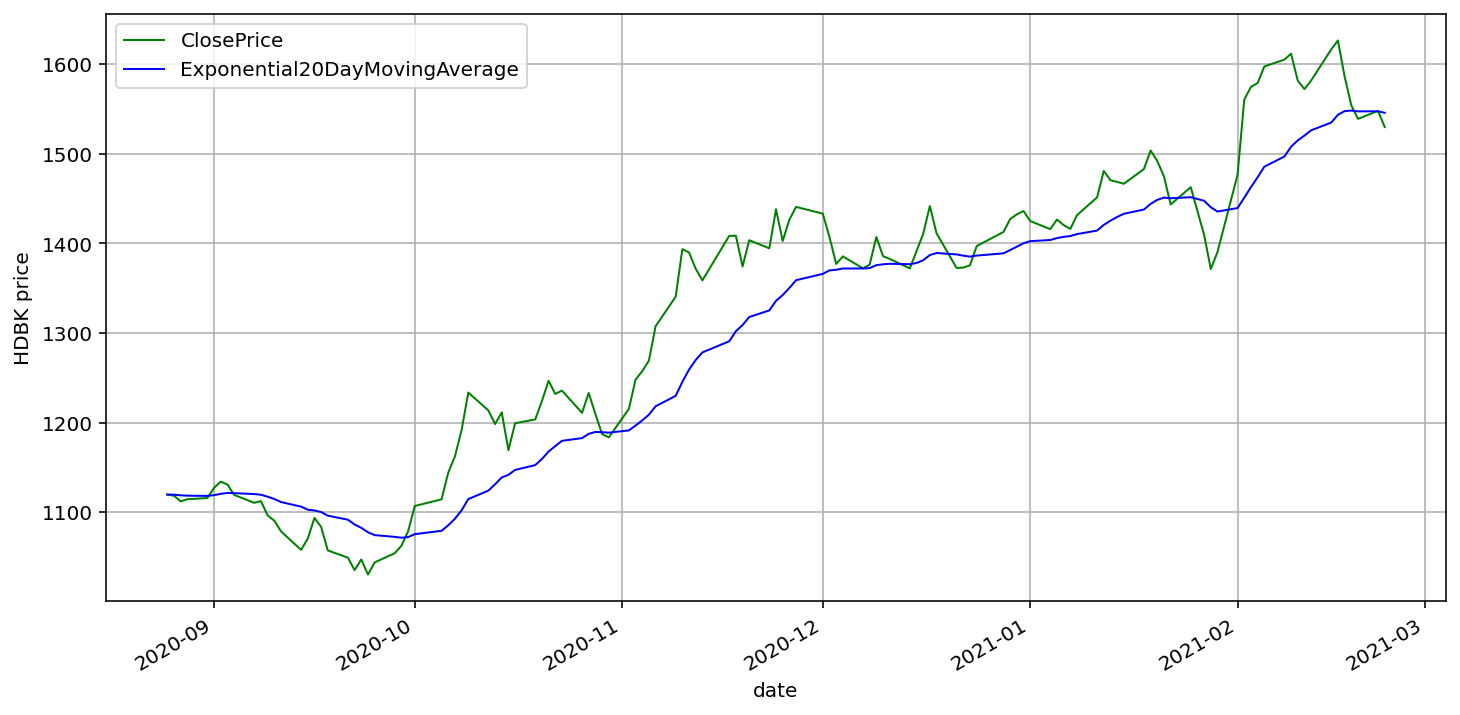

In [23]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel=f'{stock} price')
close_price.plot(ax=ax1, color='g', lw=1., legend=True)
ema.plot(ax=ax1, color='b', lw=1., legend=True)
ax1.grid(True)
plt.show()

#### Absolute Price Oscillator (APO)

In [24]:
stock_data = prices.loc[stock].tail(days)
stock_data.tail()

,close,high,low,open,volume
date,,,,,
2021-02-17,1586.5,1621.80,1583.00,1620.00,6397213
2021-02-18,1554.3,1605.95,1548.00,1605.95,7360280
2021-02-19,1539.1,1564.20,1533.00,1545.00,8569754
2021-02-22,1548.0,1573.90,1539.45,1545.05,14725919
2021-02-23,1530.0,1557.25,1523.05,1553.10,9119570


In [25]:
close = stock_data.close

In [26]:
num_periods_fast = 10 # time period for the fast EMA
K_fast = 2 / (num_periods_fast + 1) # smoothing factor for fast EMA
ema_fast = 0
num_periods_slow = 40 # time period for slow EMA
K_slow = 2 / (num_periods_slow + 1) # smoothing factor for slow EMA
ema_slow = 0

ema_fast_values = [] # we will hold fast EMA values for visualization purposes
ema_slow_values = [] # we will hold slow EMA values for visualization purposes
apo_values = [] # track computed absolute price oscillator values
for close_price in close:
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_fast + ema_fast
        ema_slow = (close_price - ema_slow) * K_slow + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    apo_values.append(ema_fast - ema_slow)

stock_data = stock_data.assign(ClosePrice=pd.Series(close, index=stock_data.index))
stock_data = stock_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=stock_data.index))
stock_data = stock_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=stock_data.index))
stock_data = stock_data.assign(AbsolutePriceOscillator=pd.Series(apo_values, index=stock_data.index))

close_price = stock_data['ClosePrice']
ema_f = stock_data['FastExponential10DayMovingAverage']
ema_s = stock_data['SlowExponential40DayMovingAverage']
apo = stock_data['AbsolutePriceOscillator']

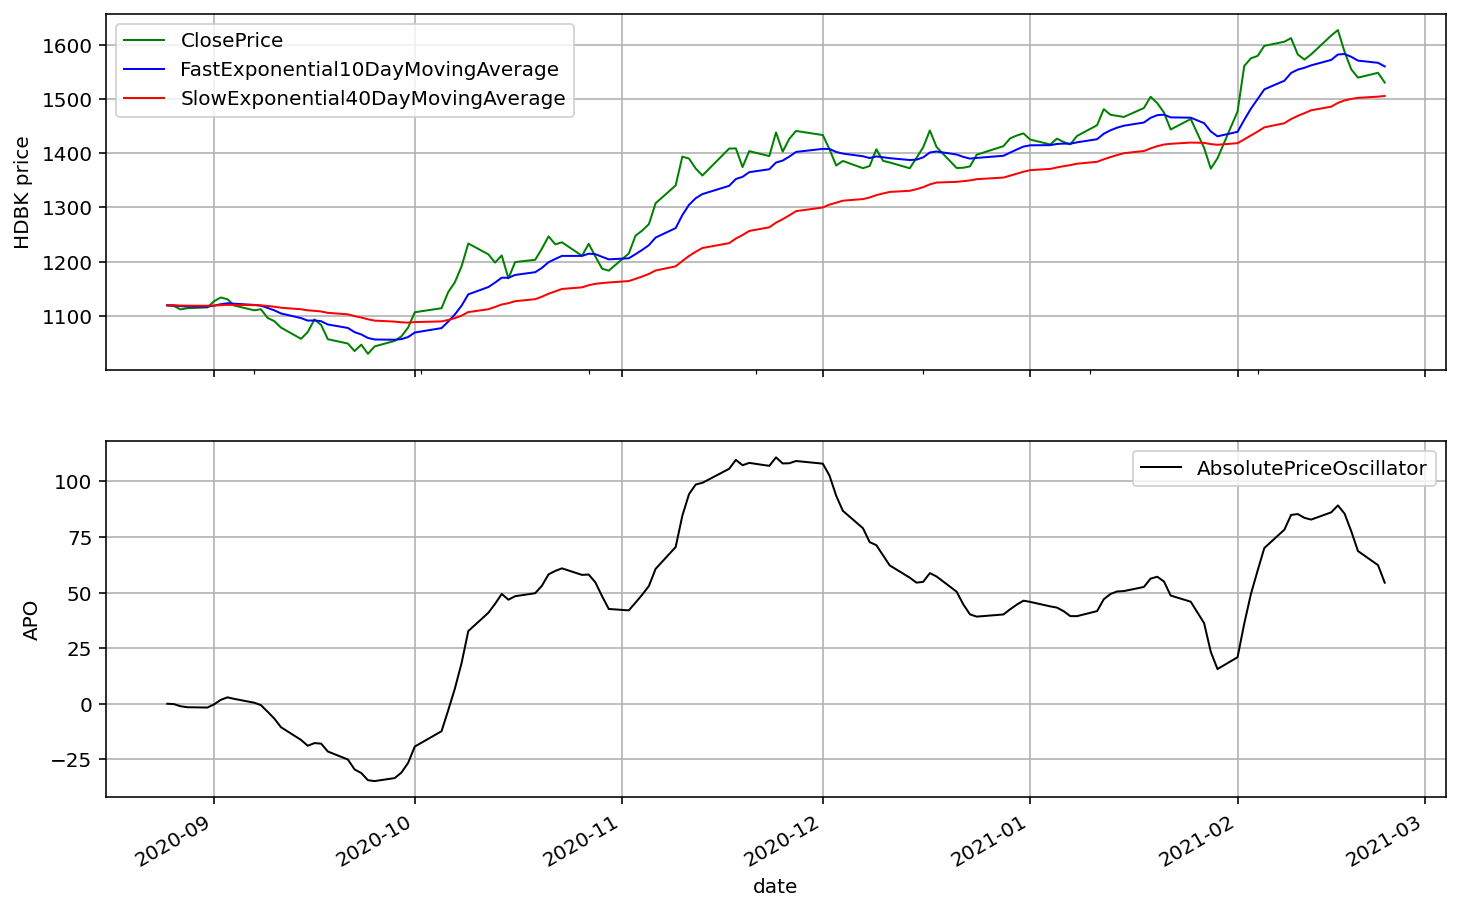

In [27]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211, ylabel=f'{stock} price')
close_price.plot(ax=ax1, color='g', lw=1., legend=True)
ema_f.plot(ax=ax1, color='b', lw=1., legend=True)
ema_s.plot(ax=ax1, color='r', lw=1., legend=True,)
ax1.grid(True)
ax2 = fig.add_subplot(212, ylabel='APO')
apo.plot(ax=ax2, color='black', lw=1., legend=True, sharex = ax1)
ax2.grid(True)
plt.show()

#### Moving Average Convergence Divergence (MACD)

In [28]:
stock_data = prices.loc[stock].tail(days)
stock_data.tail()

,close,high,low,open,volume
date,,,,,
2021-02-17,1586.5,1621.80,1583.00,1620.00,6397213
2021-02-18,1554.3,1605.95,1548.00,1605.95,7360280
2021-02-19,1539.1,1564.20,1533.00,1545.00,8569754
2021-02-22,1548.0,1573.90,1539.45,1545.05,14725919
2021-02-23,1530.0,1557.25,1523.05,1553.10,9119570


In [29]:
close = stock_data.close

In [30]:
num_periods_fast = 12 # fast EMA time period
K_fast = 2 / (num_periods_fast + 1) # fast EMA smoothing factor
ema_fast = 0
num_periods_slow = 26 # slow EMA time period
K_slow = 2 / (num_periods_slow + 1) # slow EMA smoothing factor
ema_slow = 0
num_periods_macd = 9 # MACD EMA time period
K_macd = 2 / (num_periods_macd + 1) # MACD EMA smoothing factor
ema_macd = 0

ema_fast_values = [] # track fast EMA values for visualization purposes
ema_slow_values = [] # track slow EMA values for visualization purposes
macd_values = [] # track MACD values for visualization purposes
macd_signal_values = [] # MACD EMA values tracker
macd_historgram_values = [] # MACD - MACD-EMA
for close_price in close:
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_fast + ema_fast
        ema_slow = (close_price - ema_slow) * K_slow + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    macd = ema_fast - ema_slow # MACD is fast_MA - slow_EMA
    if ema_macd == 0:
        ema_macd = macd
    else:
        ema_macd = (macd - ema_macd) * K_slow + ema_macd # signal is EMA of MACD values

    macd_values.append(macd)
    macd_signal_values.append(ema_macd)
    macd_historgram_values.append(macd - ema_macd)

stock_data = stock_data.assign(ClosePrice=pd.Series(close, index=stock_data.index))
stock_data = stock_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=stock_data.index))
stock_data = stock_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=stock_data.index))
stock_data = stock_data.assign(MovingAverageConvergenceDivergence=pd.Series(macd_values, index=stock_data.index))
stock_data = stock_data.assign(Exponential20DayMovingAverageOfMACD=pd.Series(macd_signal_values, index=stock_data.index))
stock_data = stock_data.assign(MACDHistorgram=pd.Series(macd_historgram_values, index=stock_data.index))

close_price = stock_data['ClosePrice']
ema_f = stock_data['FastExponential10DayMovingAverage']
ema_s = stock_data['SlowExponential40DayMovingAverage']
macd = stock_data['MovingAverageConvergenceDivergence']
ema_macd = stock_data['Exponential20DayMovingAverageOfMACD']
macd_histogram = stock_data['MACDHistorgram']

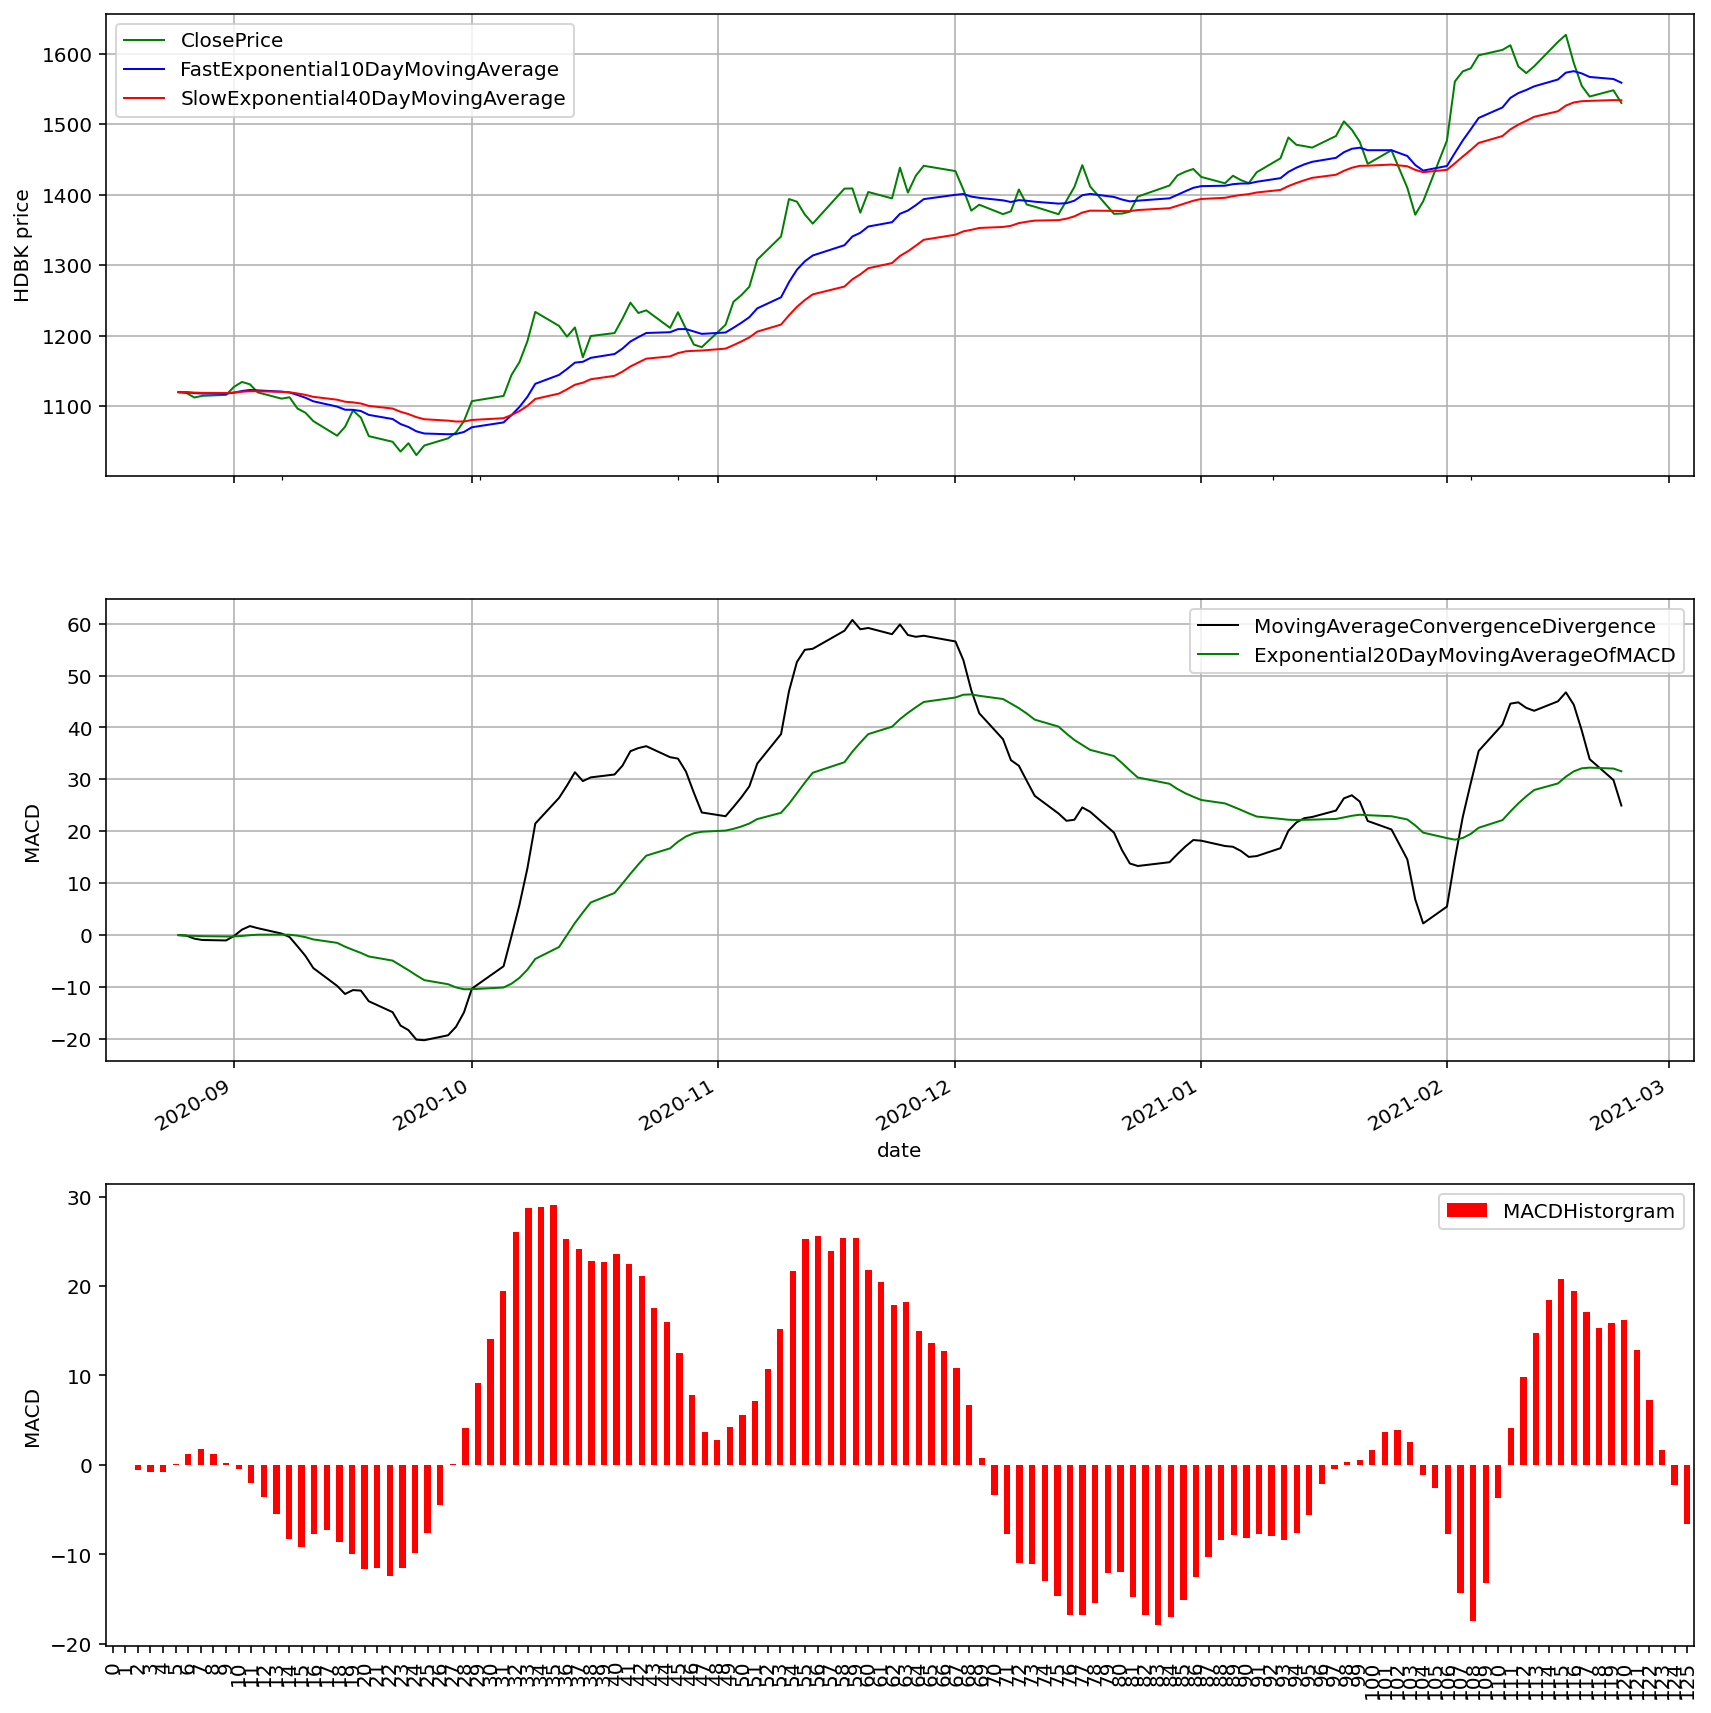

In [31]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(311, ylabel=f'{stock} price', sharex = ax1)
close_price.plot(ax=ax1, color='g', lw=1., legend=True)
ema_f.plot(ax=ax1, color='b', lw=1., legend=True)
ema_s.plot(ax=ax1, color='r', lw=1., legend=True)
ax1.grid(True)
ax2 = fig.add_subplot(312, ylabel='MACD', )
macd.plot(ax=ax2, color='black', lw=1., legend=True)
ema_macd.plot(ax=ax2, color='g', lw=1., legend=True)
ax2.grid(True)
ax3 = fig.add_subplot(313, ylabel='MACD')
macd_histogram.plot(ax=ax3, color='r', kind='bar', legend=True, use_index=False)
plt.legend()
plt.tight_layout()

#### Bollinger bands (BBANDS)

In [32]:
stock_data = prices.loc[stock].tail(days)
stock_data.tail()

,close,high,low,open,volume
date,,,,,
2021-02-17,1586.5,1621.80,1583.00,1620.00,6397213
2021-02-18,1554.3,1605.95,1548.00,1605.95,7360280
2021-02-19,1539.1,1564.20,1533.00,1545.00,8569754
2021-02-22,1548.0,1573.90,1539.45,1545.05,14725919
2021-02-23,1530.0,1557.25,1523.05,1553.10,9119570


In [33]:
close = stock_data.close

In [34]:
time_period = 20 # history length for Simple Moving Average for middle band
stdev_factor = 2 # Standard Deviation Scaling factor for the upper and lower bands
history = [] # price history for computing simple moving average
sma_values = [] # moving average of prices for visualization purposes
upper_band = [] # upper band values
lower_band = [] # lower band values

for close_price in close:
    history.append(close_price)
    if len(history) > time_period: # we only want to maintain at most 'time_period' number of price observations
        del (history[0])

    sma = stats.mean(history)
    sma_values.append(sma) # simple moving average or middle band
    variance = 0 # variance is the square of standard deviation
    for hist_price in history:
        variance = variance + ((hist_price - sma) ** 2)

    stdev = math.sqrt(variance / len(history)) # use square root to get standard deviation

    upper_band.append(sma + stdev_factor * stdev)
    lower_band.append(sma - stdev_factor * stdev)

stock_data = stock_data.assign(ClosePrice=pd.Series(close, index=stock_data.index))
stock_data = stock_data.assign(MiddleBollingerBand20DaySMA=pd.Series(sma_values, index=stock_data.index))
stock_data = stock_data.assign(UpperBollingerBand20DaySMA2StdevFactor=pd.Series(upper_band, index=stock_data.index))
stock_data = stock_data.assign(LowerBollingerBand20DaySMA2StdevFactor=pd.Series(lower_band, index=stock_data.index))

close_price = stock_data['ClosePrice']
mband = stock_data['MiddleBollingerBand20DaySMA']
uband = stock_data['UpperBollingerBand20DaySMA2StdevFactor']
lband = stock_data['LowerBollingerBand20DaySMA2StdevFactor']

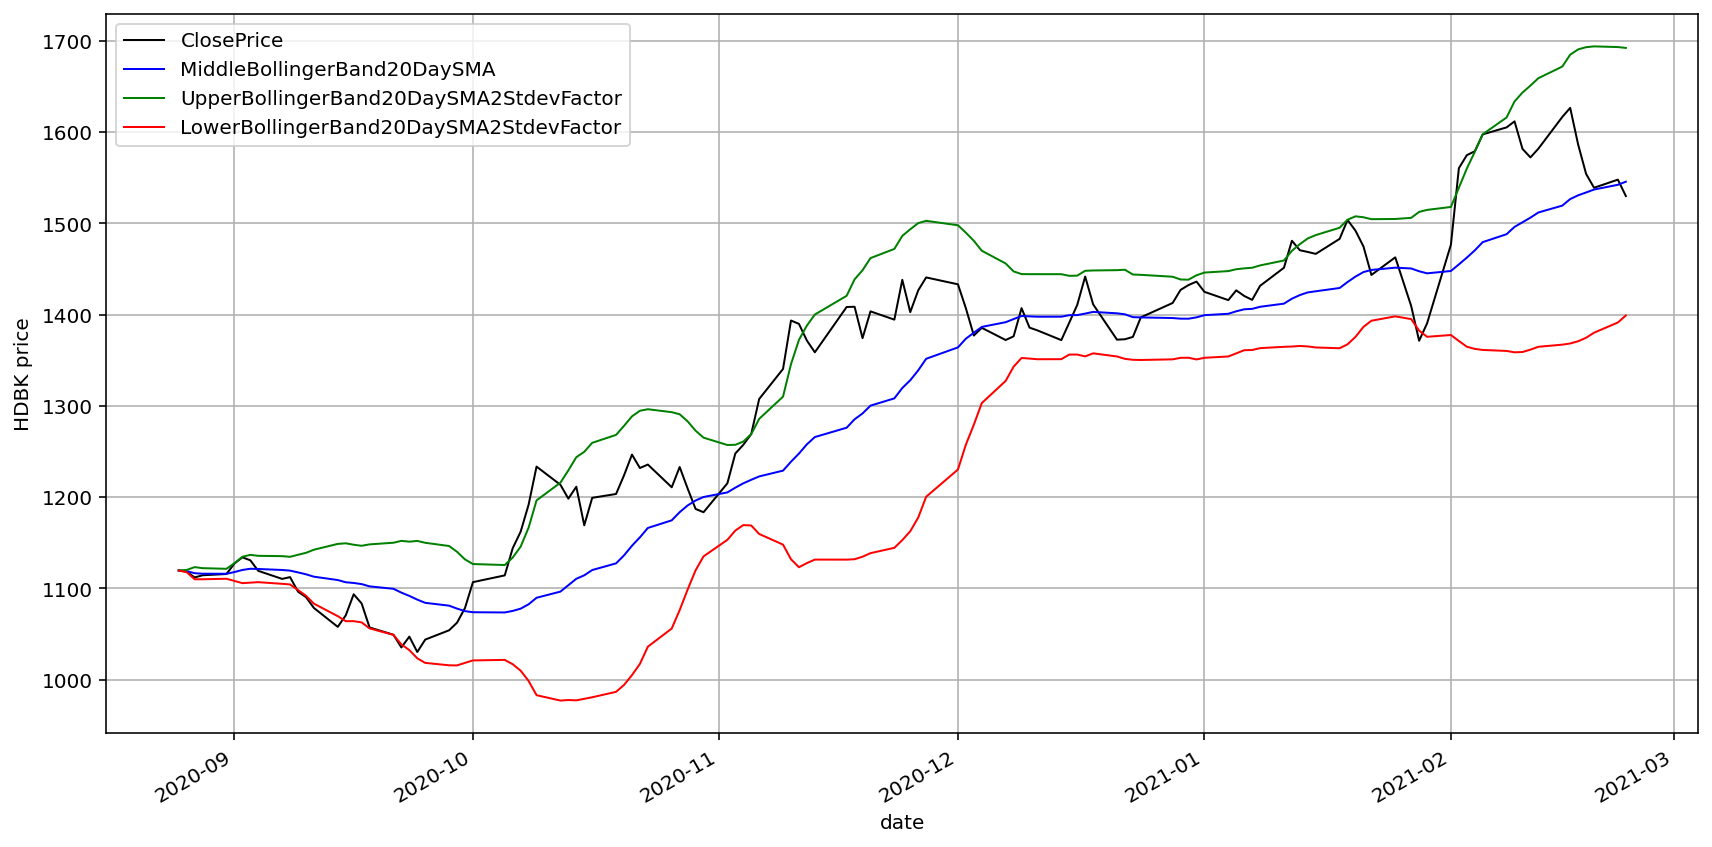

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel=f'{stock} price')
close_price.plot(ax=ax1, color='k', lw=1., legend=True)
mband.plot(ax=ax1, color='b', lw=1., legend=True)
uband.plot(ax=ax1, color='g', lw=1., legend=True)
lband.plot(ax=ax1, color='r', lw=1., legend=True)
ax1.grid(True)
plt.tight_layout()
plt.show()

#### Relative strength indicator(RSI)

In [36]:
stock_data = prices.loc[stock].tail(days)
stock_data.tail()

,close,high,low,open,volume
date,,,,,
2021-02-17,1586.5,1621.80,1583.00,1620.00,6397213
2021-02-18,1554.3,1605.95,1548.00,1605.95,7360280
2021-02-19,1539.1,1564.20,1533.00,1545.00,8569754
2021-02-22,1548.0,1573.90,1539.45,1545.05,14725919
2021-02-23,1530.0,1557.25,1523.05,1553.10,9119570


In [37]:
close = stock_data.close

In [38]:
import statistics as stats

time_period = 14 # look back period to compute gains & losses
gain_history = [] # history of gains over look back period (0 if no gain, magnitude of gain if gain)
loss_history = [] # history of losses over look back period (0 if no loss, magnitude of loss if loss)
avg_gain_values = [] # track avg gains for visualization purposes
avg_loss_values = [] # track avg losses for visualization purposes
rsi_values = [] # track computed RSI values
last_price = 0 # current_price - last_price > 0 => gain. current_price - last_price < 0 => loss.

for close_price in close:
    if last_price == 0:
        last_price = close_price

    gain_history.append(max(0, close_price - last_price))
    loss_history.append(max(0, last_price - close_price))
    last_price = close_price

    if len(gain_history) > time_period: # maximum observations is equal to lookback period
        del (gain_history[0])
        del (loss_history[0])

    avg_gain = stats.mean(gain_history) # average gain over lookback period
    avg_loss = stats.mean(loss_history) # average loss over lookback period

    avg_gain_values.append(avg_gain)
    avg_loss_values.append(avg_loss)

    rs = 0
    if avg_loss > 0: # to avoid division by 0, which is undefined
        rs = avg_gain / avg_loss

    rsi = 100 - (100 / (1 + rs))
    rsi_values.append(rsi)

stock_data = stock_data.assign(ClosePrice=pd.Series(close, index=stock_data.index))
stock_data = stock_data.assign(RelativeStrengthAvgGainOver14Days=pd.Series(avg_gain_values, index=stock_data.index))
stock_data = stock_data.assign(RelativeStrengthAvgLossOver14Days=pd.Series(avg_loss_values, index=stock_data.index))
stock_data = stock_data.assign(RelativeStrengthIndicatorOver14Days=pd.Series(rsi_values, index=stock_data.index))

close_price = stock_data['ClosePrice']
rs_gain = stock_data['RelativeStrengthAvgGainOver14Days']
rs_loss = stock_data['RelativeStrengthAvgLossOver14Days']
rsi = stock_data['RelativeStrengthIndicatorOver14Days']

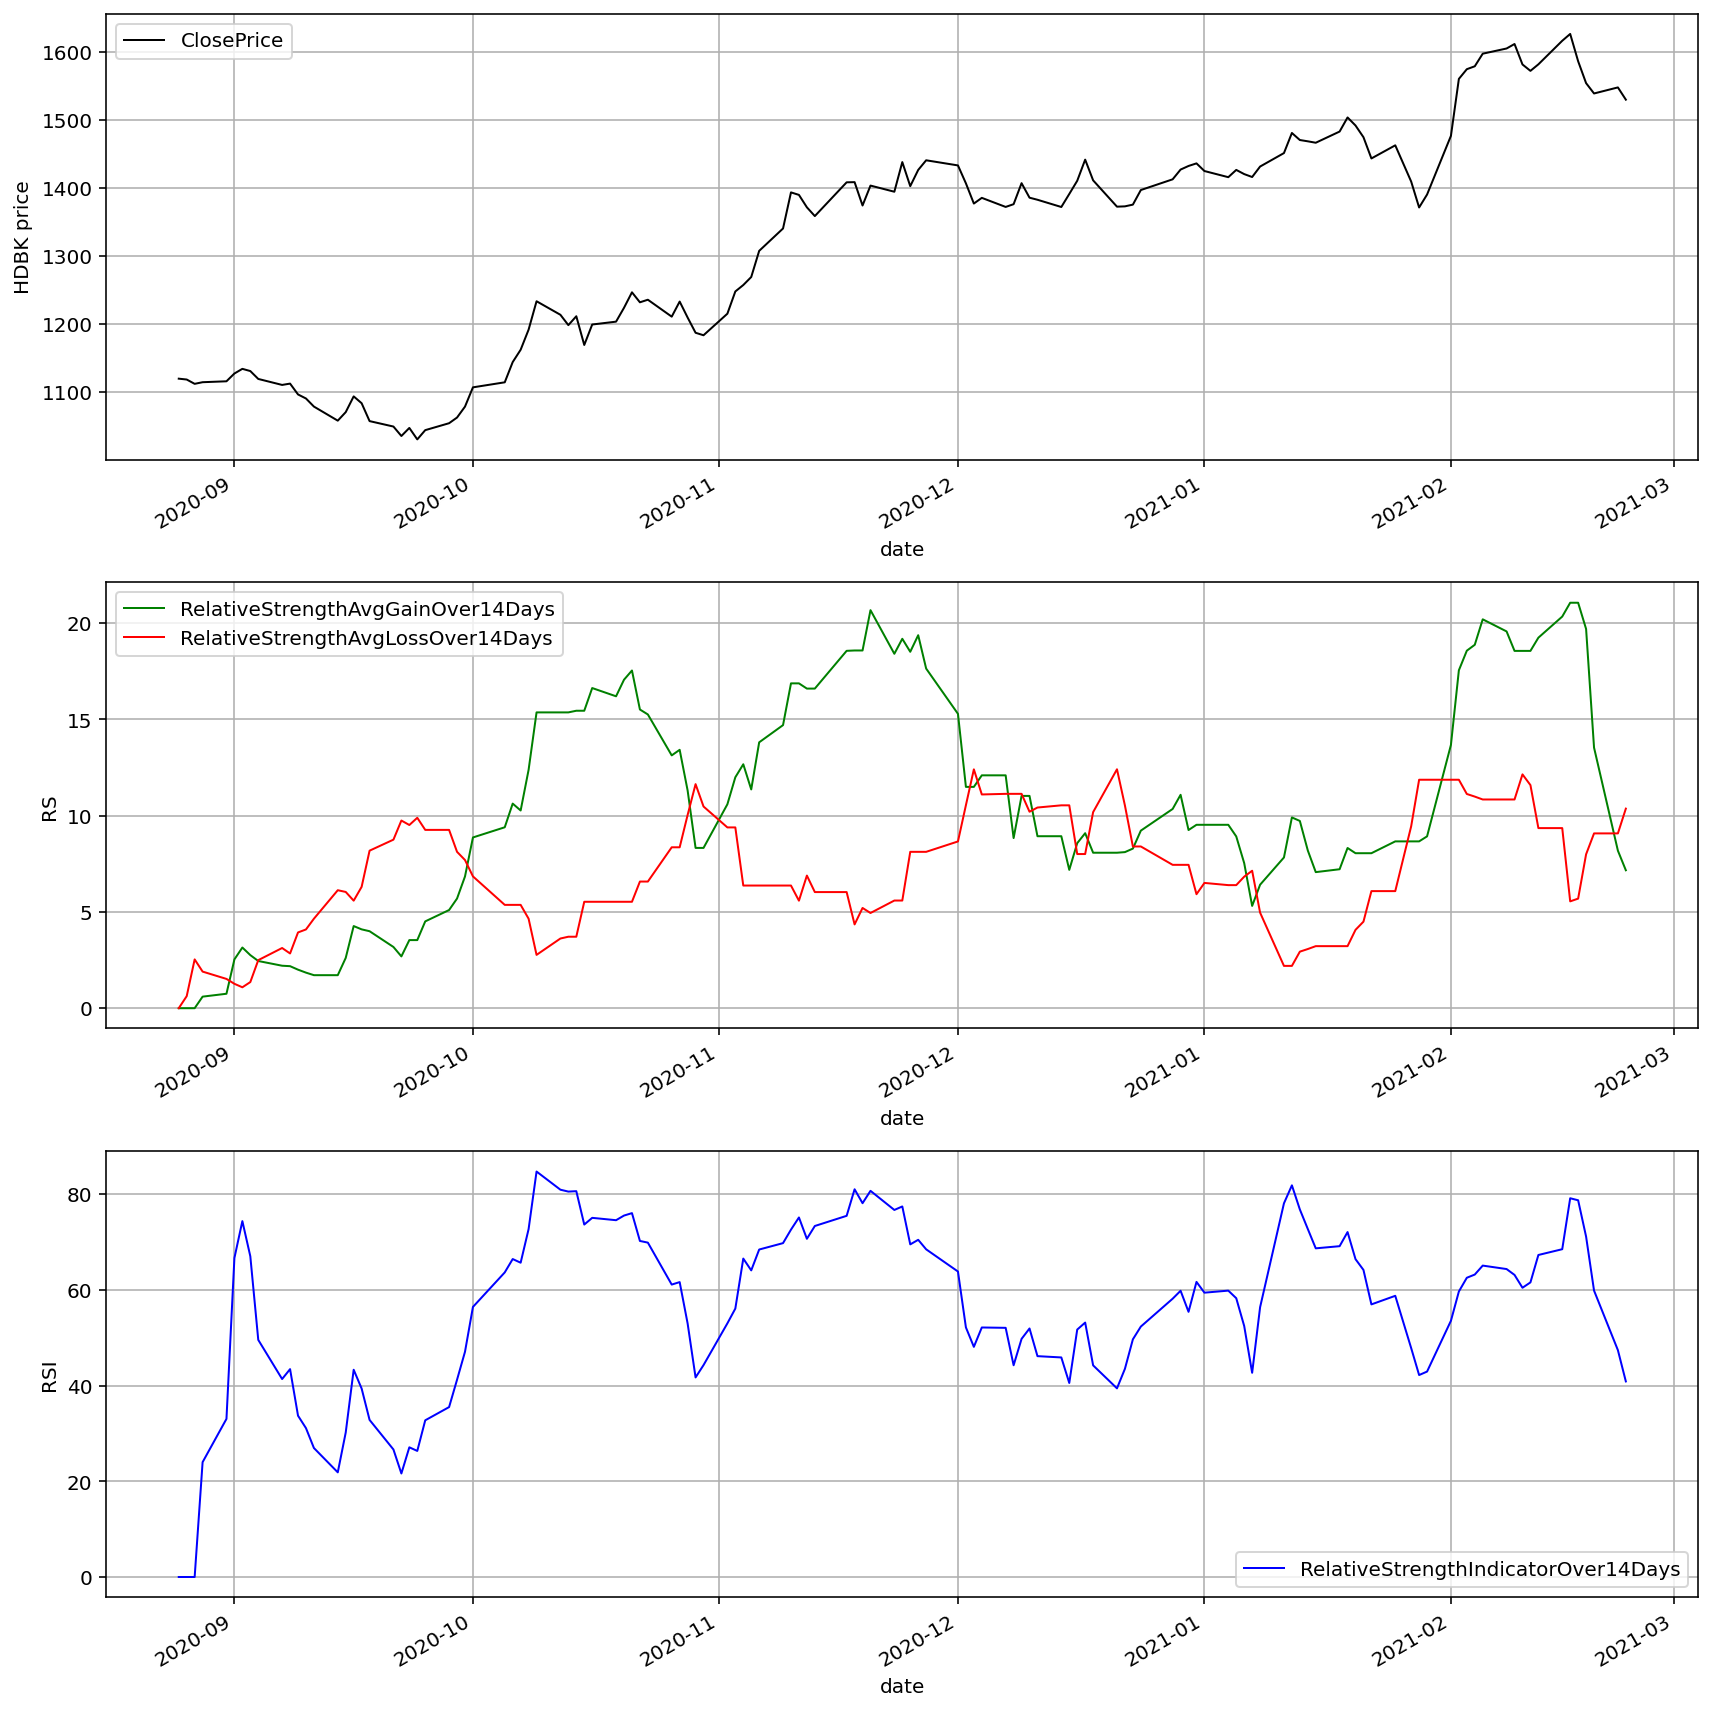

In [39]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(311, ylabel=f'{stock} price')
close_price.plot(ax=ax1, color='black', lw=1., legend=True)
ax1.grid(True)
ax2 = fig.add_subplot(312, ylabel='RS')
rs_gain.plot(ax=ax2, color='g', lw=1., legend=True)
rs_loss.plot(ax=ax2, color='r', lw=1., legend=True)
ax2.grid(True)
ax3 = fig.add_subplot(313, ylabel='RSI')
rsi.plot(ax=ax3, color='b', lw=1., legend=True)
ax3.grid(True)
plt.tight_layout()
plt.show()

#### Standard deviation

In [40]:
stock_data = prices.loc[stock].tail(days)
stock_data.tail()

,close,high,low,open,volume
date,,,,,
2021-02-17,1586.5,1621.80,1583.00,1620.00,6397213
2021-02-18,1554.3,1605.95,1548.00,1605.95,7360280
2021-02-19,1539.1,1564.20,1533.00,1545.00,8569754
2021-02-22,1548.0,1573.90,1539.45,1545.05,14725919
2021-02-23,1530.0,1557.25,1523.05,1553.10,9119570


In [41]:
close = stock_data.close

In [42]:
time_period = 20 # look back period
history = [] # history of prices
sma_values = [] # to track moving average values for visualization purposes
stddev_values = [] # history of computed stdev values

for close_price in close:
    history.append(close_price)
    if len(history) > time_period: # we track at most 'time_period' number of prices
        del (history[0])

    sma = stats.mean(history)
    sma_values.append(sma)
    variance = 0 # variance is square of standard deviation
    for hist_price in history:
        variance = variance + ((hist_price - sma) ** 2)

    stdev = math.sqrt(variance / len(history))
    stddev_values.append(stdev)

stock_data = stock_data.assign(ClosePrice=pd.Series(close, index=stock_data.index))
stock_data = stock_data.assign(StandardDeviationOver20Days=pd.Series(stddev_values, index=stock_data.index))

close_price = stock_data['ClosePrice']
stddev = stock_data['StandardDeviationOver20Days']

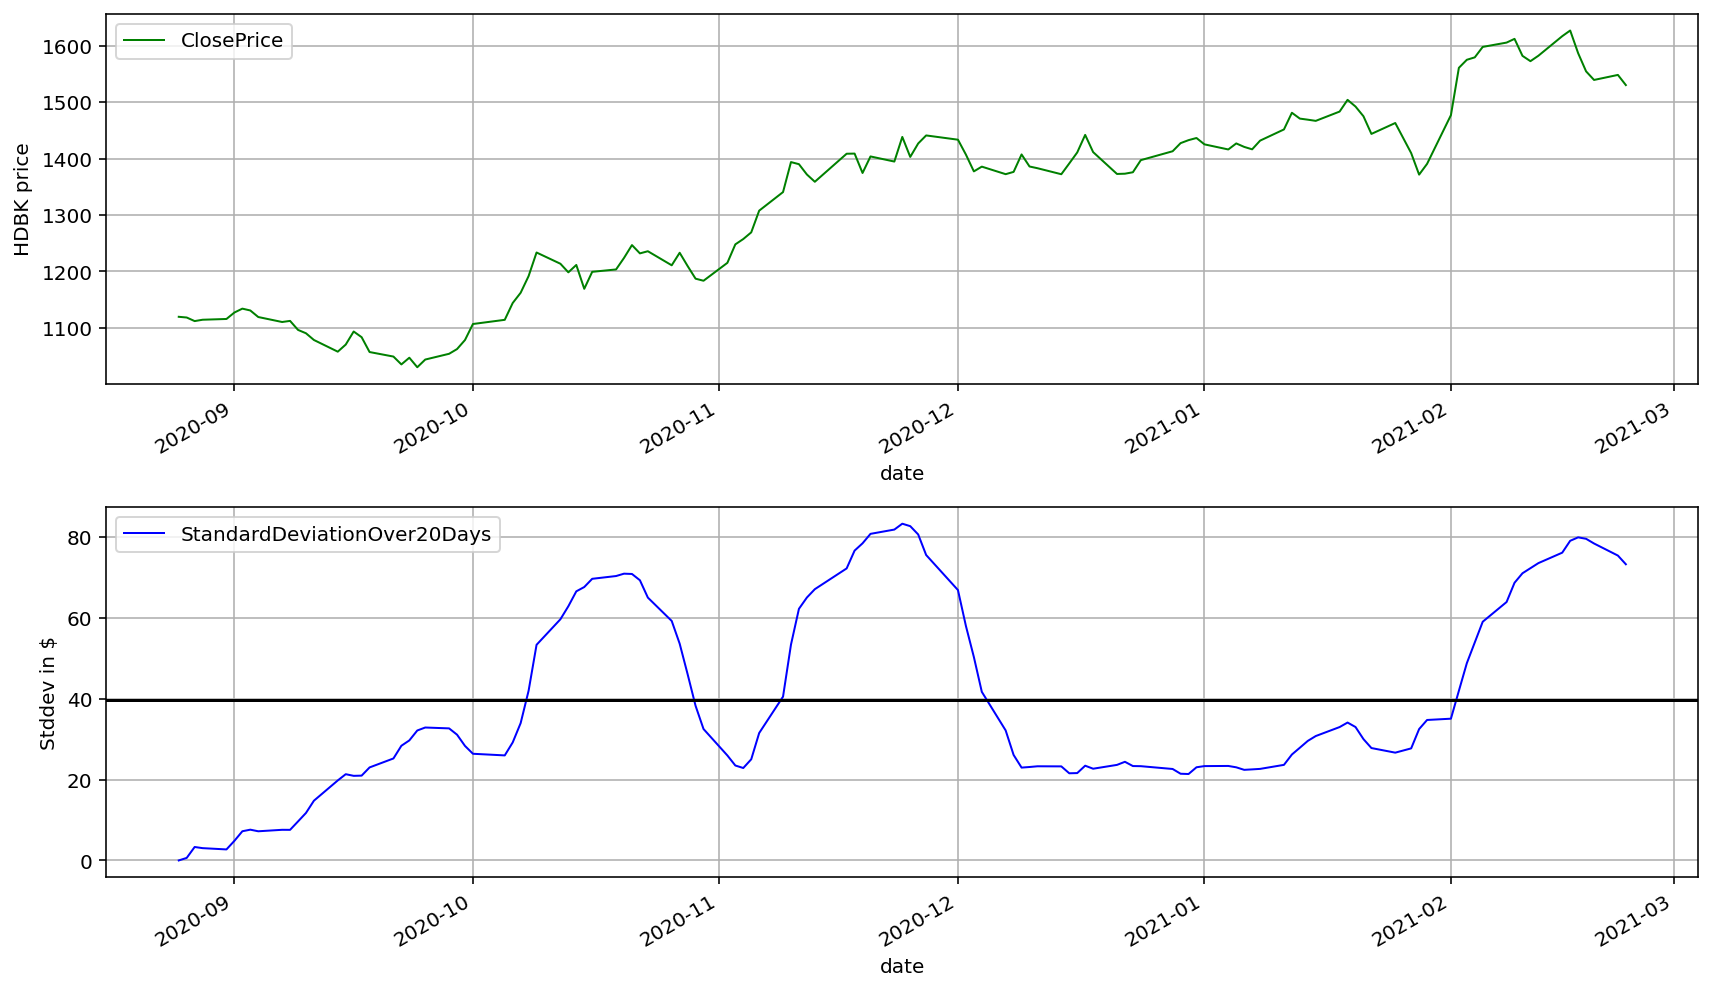

In [43]:
fig = plt.figure(figsize = (12,7))
ax1 = fig.add_subplot(211, ylabel=f'{stock} price')
close_price.plot(ax=ax1, color='g', lw=1., legend=True)
ax1.grid(True)
ax2 = fig.add_subplot(212, ylabel='Stddev in $')
stddev.plot(ax=ax2, color='b', lw=1., legend=True)
ax2.axhline(y=stats.mean(stddev_values), color='k')
ax2.grid(True)
plt.tight_layout()

#### Momentum

In [44]:
stock_data = prices.loc[stock].tail(days)
stock_data.tail()

,close,high,low,open,volume
date,,,,,
2021-02-17,1586.5,1621.80,1583.00,1620.00,6397213
2021-02-18,1554.3,1605.95,1548.00,1605.95,7360280
2021-02-19,1539.1,1564.20,1533.00,1545.00,8569754
2021-02-22,1548.0,1573.90,1539.45,1545.05,14725919
2021-02-23,1530.0,1557.25,1523.05,1553.10,9119570


In [45]:
close = stock_data.close

In [46]:
time_period = 20 # how far to look back to find reference price to compute momentum
history = [] # history of observed prices to use in momentum calculation
mom_values = [] # track momentum values for visualization purposes

for close_price in close:
    history.append(close_price)
    if len(history) > time_period: # history is at most 'time_period' number of observations
        del (history[0])

    mom = close_price - history[0]
    mom_values.append(mom)

stock_data = stock_data.assign(ClosePrice=pd.Series(close, index=stock_data.index))
stock_data = stock_data.assign(MomentumFromPrice20DaysAgo=pd.Series(mom_values, index=stock_data.index))

close_price = stock_data['ClosePrice']
mom = stock_data['MomentumFromPrice20DaysAgo']

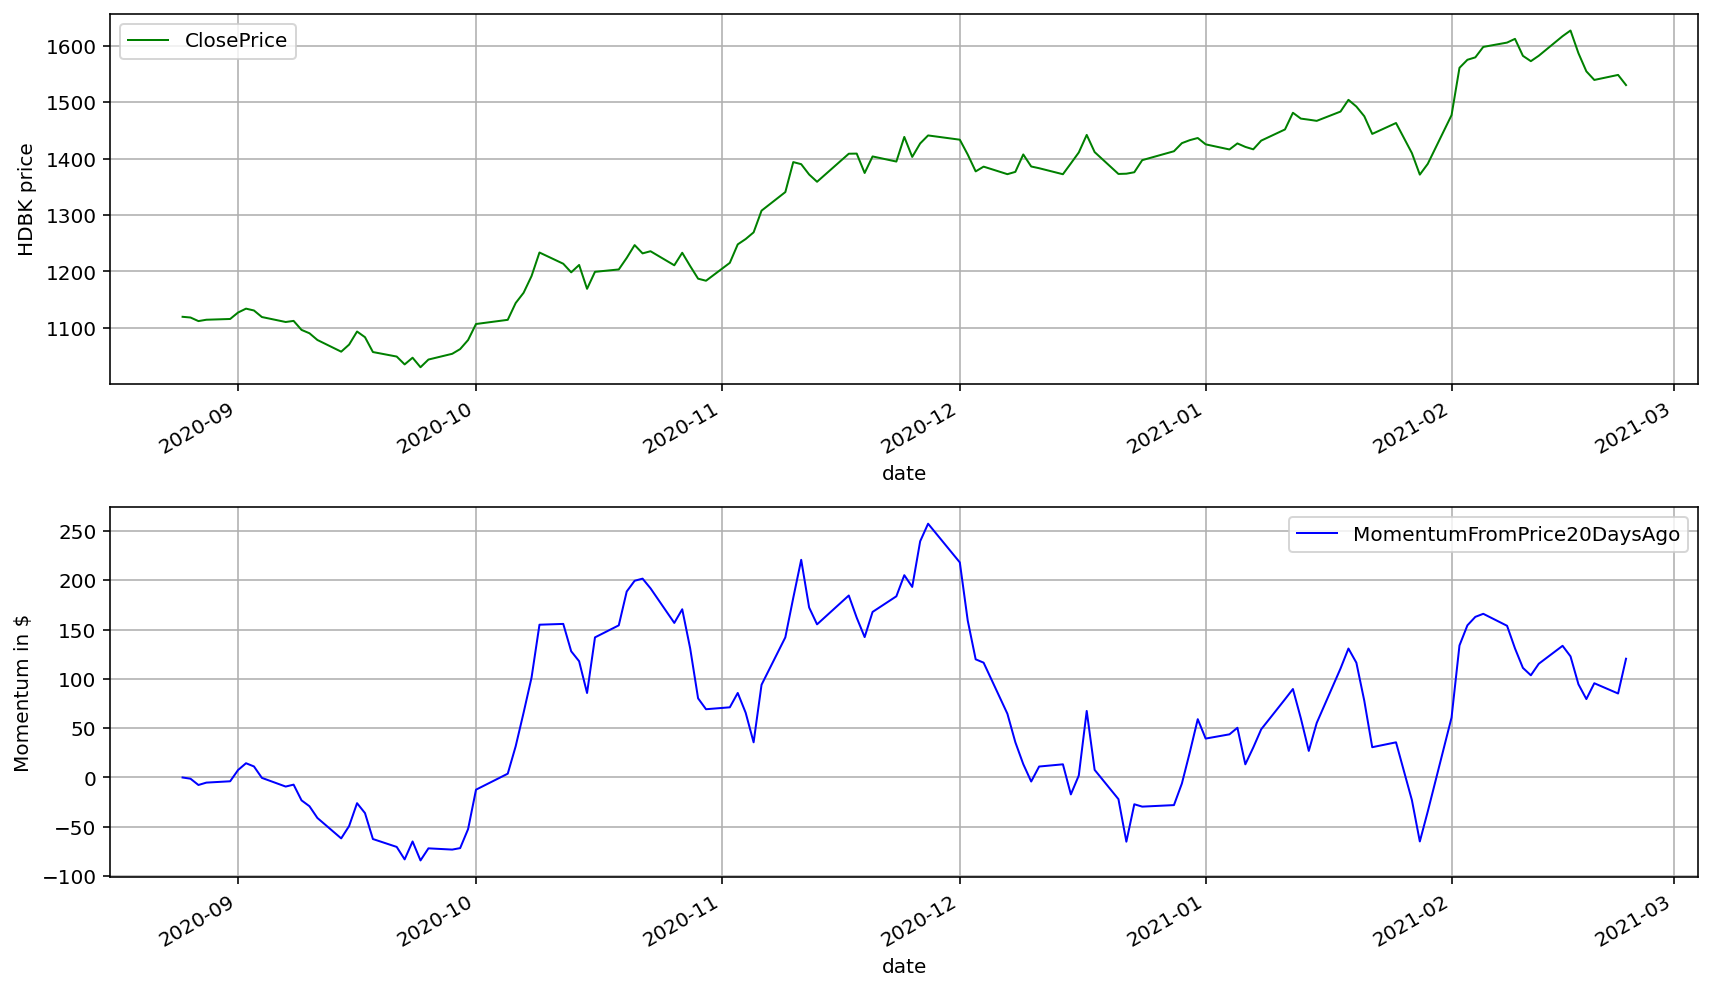

In [47]:
fig = plt.figure(figsize = (12,7))
ax1 = fig.add_subplot(211, ylabel=f'{stock} price')
close_price.plot(ax=ax1, color='g', lw=1., legend=True)
ax1.grid(True)
ax2 = fig.add_subplot(212, ylabel='Momentum in $')
mom.plot(ax=ax2, color='b', lw=1., legend=True)
ax2.grid(True)
plt.tight_layout()
plt.show()

#### Seasonality

In [48]:
stock_data = prices.loc[stock].tail(days)
stock_data.tail()

,close,high,low,open,volume
date,,,,,
2021-02-17,1586.5,1621.80,1583.00,1620.00,6397213
2021-02-18,1554.3,1605.95,1548.00,1605.95,7360280
2021-02-19,1539.1,1564.20,1533.00,1545.00,8569754
2021-02-22,1548.0,1573.90,1539.45,1545.05,14725919
2021-02-23,1530.0,1557.25,1523.05,1553.10,9119570


In [49]:
close = stock_data.close

In [50]:
stock_monthly_return =close.pct_change().groupby([close.index.year,close.index.month]).mean()

In [51]:
stock_monthly_return.head()

date  date
2020  8      -0.000856
      9      -0.001463
      10      0.004617
      11      0.010596
      12     -0.000045
Name: close, dtype: float64

In [52]:
stock_monthly_return.iloc[0]

-0.0008561214351374968

In [53]:
stock_monthly_return_list=[]
for i in range(len(stock_monthly_return)):  
    stock_monthly_return_list.append({'month':stock_monthly_return.index[i][1],
                                    'monthly_return': stock_monthly_return.iloc[i]})
    
# goog_montly_return_list=[]
# for i in range(len(goog_monthly_return)):  
#     goog_montly_return_list.append({'month':goog_monthly_return.index[i][1],
#                                     'monthly_return': goog_monthly_return[i]})

In [54]:
stock_monthly_return_list=pd.DataFrame(stock_monthly_return_list,columns=('month','monthly_return'))
stock_monthly_return_list.head()

,month,monthly_return
0,8,-0.000856
1,9,-0.001463
2,10,0.004617
3,11,0.010596
4,12,-0.000045


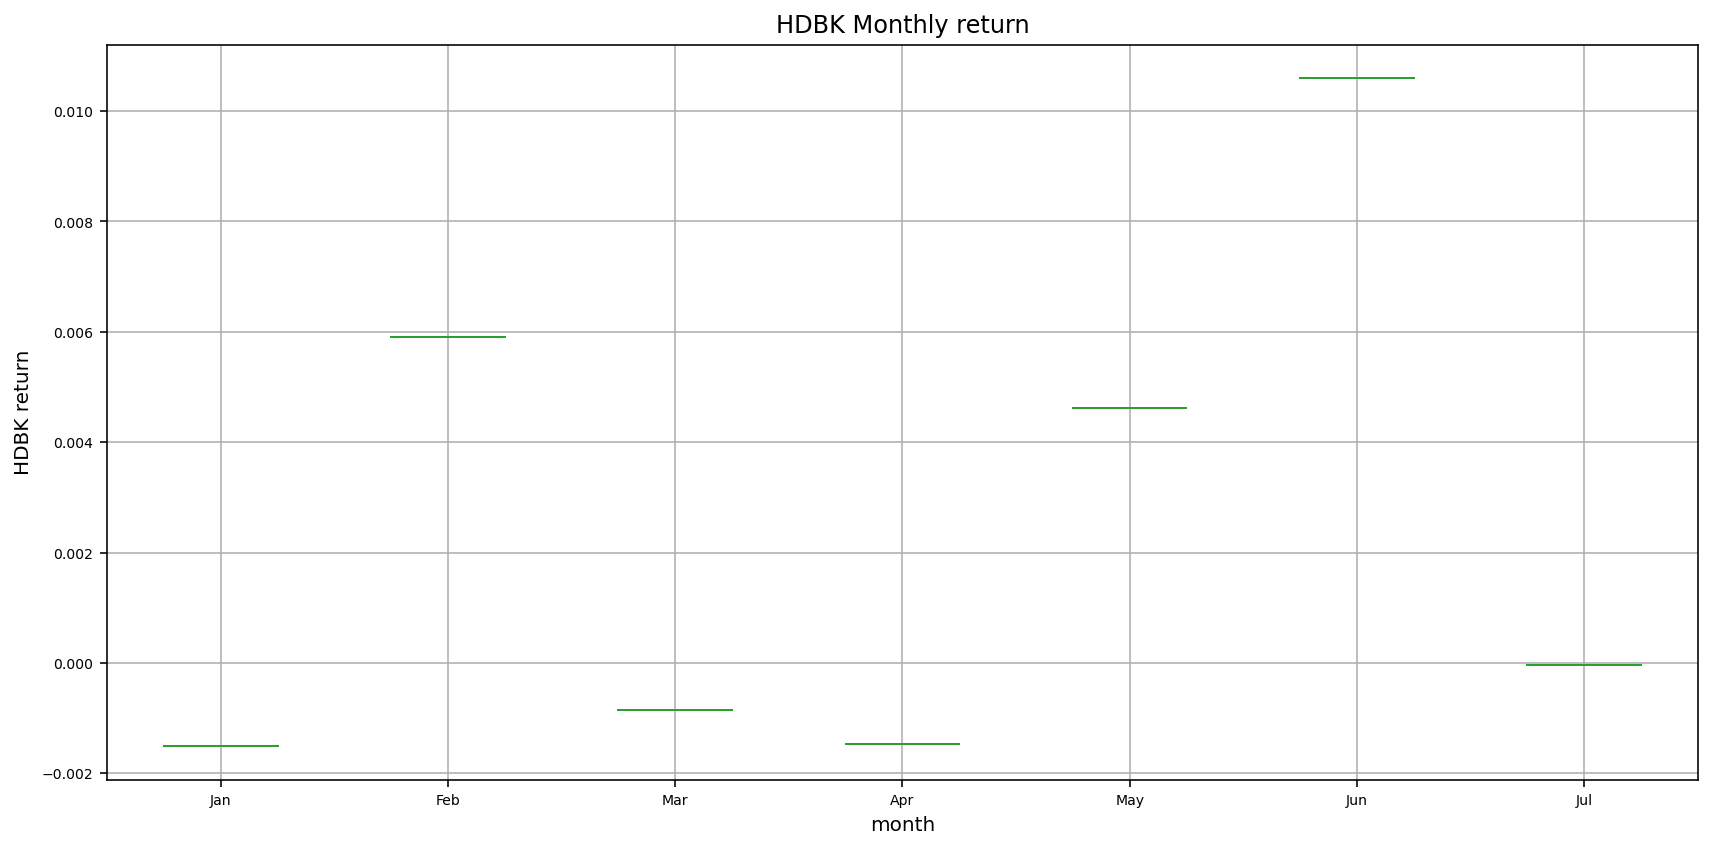

In [55]:
stock_monthly_return_list.boxplot(column='monthly_return',by='month')
ax = plt.gca()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticklabels(labels)
ax.set_ylabel(f'{stock} return')
plt.tick_params(axis='both', which='major', labelsize=7)
plt.title(f'{stock} Monthly return')
plt.suptitle("")
plt.tight_layout()

In [56]:
# stock_monthly_return_list.head(24)

In [57]:
# Displaying rolling statistics
def plot_rolling_statistics_ts(ts, titletext,ytext,window_size=12):  
    fig = plt.figure(figsize = (12,6))
    ts.plot(color='red', label='Original', lw=0.5)  
    ts.rolling(window_size).mean().plot(color='blue',label='Rolling Mean')  
    ts.rolling(window_size).std().plot(color='black', label='Rolling Std')  
    plt.legend(loc='best')  
    plt.ylabel(ytext)  
    plt.title(titletext)  
    plt.show(block=False)
    plt.tight_layout();

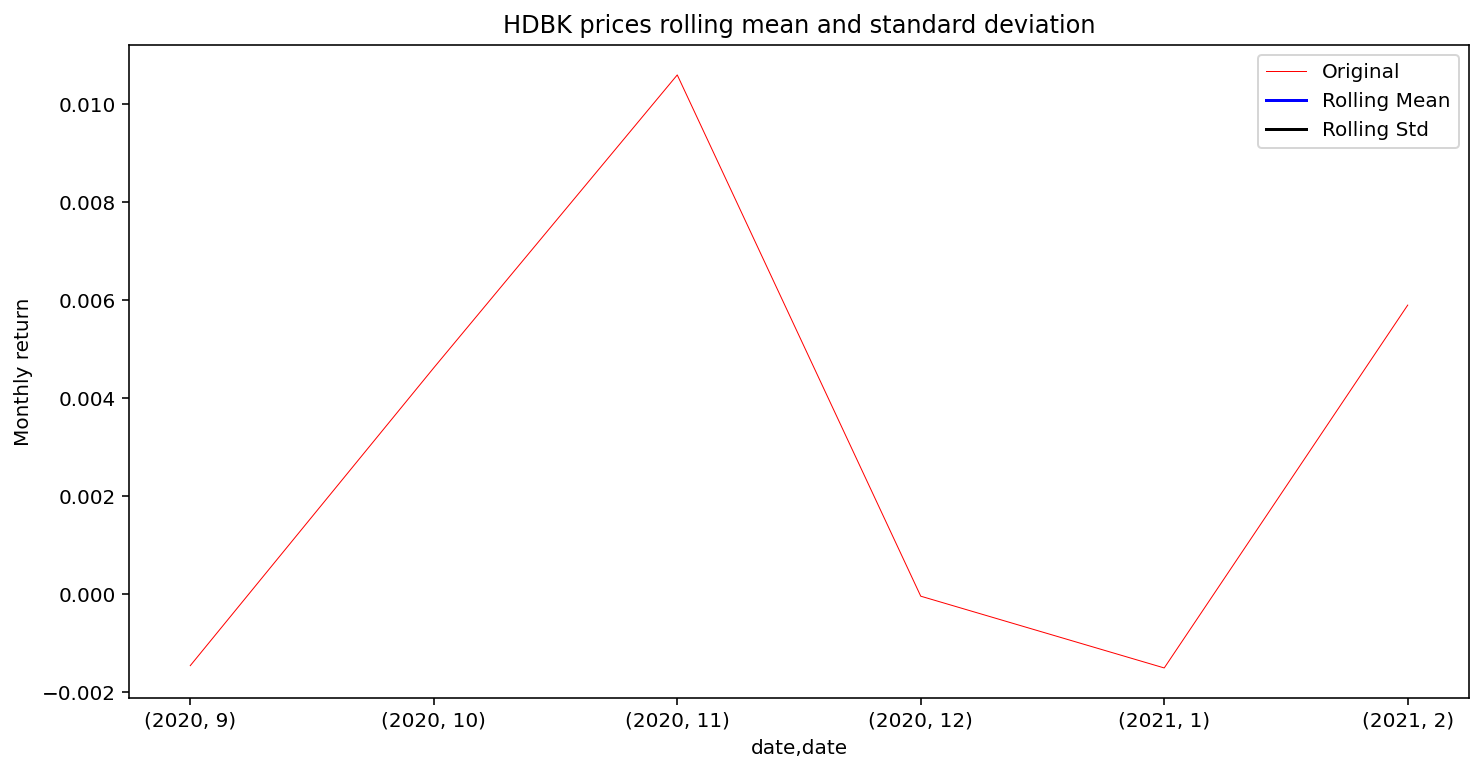

<Figure size 864x432 with 0 Axes>

In [58]:
plot_rolling_statistics_ts(stock_monthly_return[1:],f'{stock} prices rolling mean and standard deviation','Monthly return')

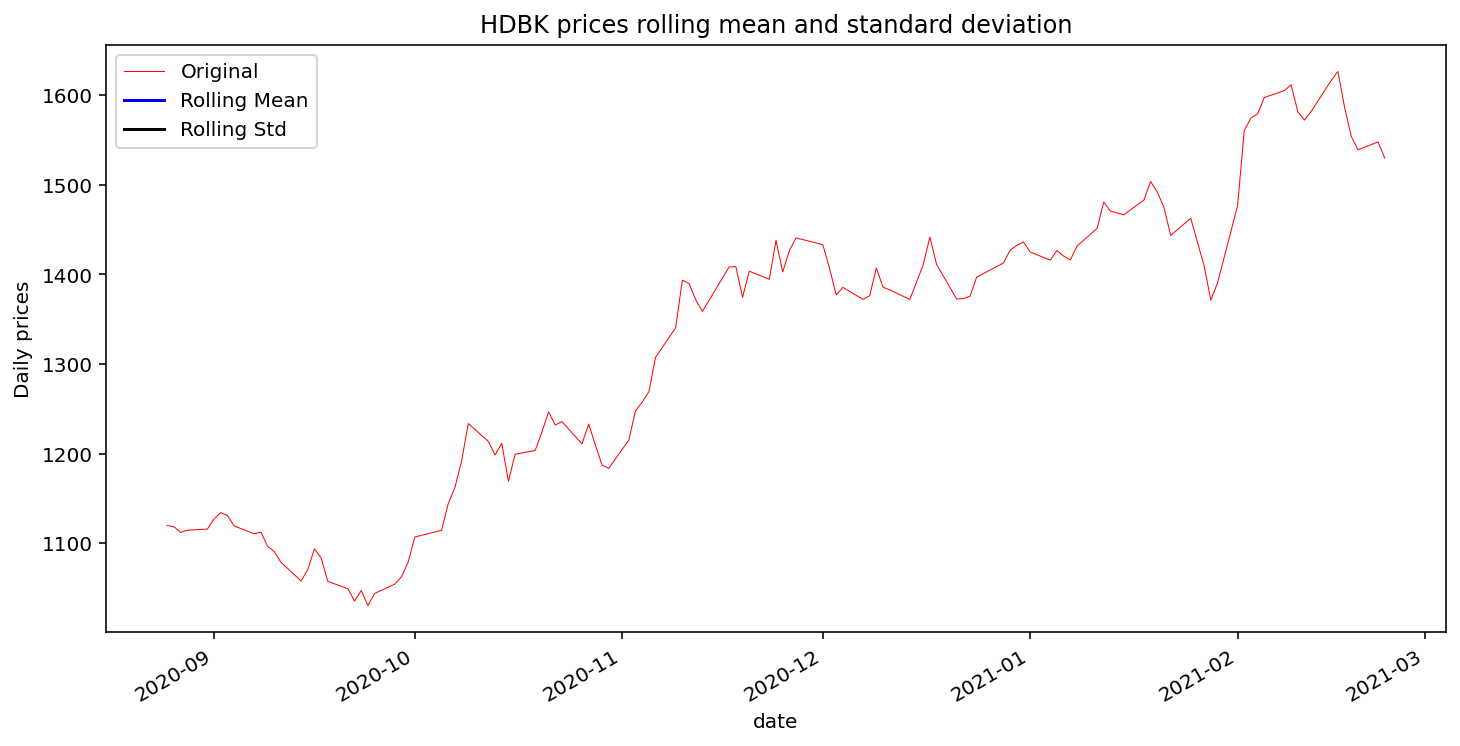

<Figure size 864x432 with 0 Axes>

In [59]:
plot_rolling_statistics_ts(close,f'{stock} prices rolling mean and standard deviation','Daily prices',365)